# Automated DDoS Attack Detection in SDN

## 1. Importing Libraries

In [ ]:
import warnings

In [ ]:
!pip install tabulate

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
!pip install keras
!pip install tensorflow
import numpy as numpy
import pandas as pd , scipy, numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU
from keras.layers import Dropout, Activation, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras import layers
import keras
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


## 2. Dataset
The dataset used for this project: [DDoS Attack SDN Dataset](https://data.mendeley.com/datasets/jxpfjc64kr/1)  
This dataset is SDN-specific and has been generated using `mininet` emulator.

In [ ]:
df=pd.read_csv('dataset_sdn.csv')
df.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


##label:
###1 - Malicious
###0 - Benign

In [ ]:
df.shape

(104345, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [ ]:
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')

In [ ]:
df.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
count,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,1.043450e+05,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,104345.000000,104345.000000,104345.000000,1.043450e+05,1.043450e+05,104345.000000,103839.000000,103839.000000,104345.000000
mean,17927.514169,4.214260,52860.954746,3.818660e+07,321.497398,4.613880e+08,3.218865e+11,5.654234,5200.383468,6381.715291,4.716150e+06,212.210676,0.600987,2.331094,9.325264e+07,9.328039e+07,998.899756,1003.811420,2007.578742,0.390857
std,11977.642655,1.956327,52023.241460,4.877748e+07,283.518232,2.770019e+08,2.834029e+11,2.950036,5257.001450,7404.777808,7.560116e+06,246.855123,0.489698,1.084333,1.519380e+08,1.330004e+08,2423.471618,2054.887034,3144.437173,0.487945
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000
25%,7098.000000,3.000000,808.000000,7.957600e+04,127.000000,2.340000e+08,1.270000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.743000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000
50%,11905.000000,4.000000,42828.000000,6.471930e+06,251.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8305.000000,5.521680e+05,276.000000,1.000000,2.000000,4.219610e+06,1.338339e+07,0.000000,0.000000,4.000000,0.000000
75%,29952.000000,5.000000,94796.000000,7.620354e+07,412.000000,7.030000e+08,4.130000e+11,7.000000,7462.000000,10017.000000,9.728112e+06,333.000000,1.000000,3.000000,1.356398e+08,1.439277e+08,251.000000,557.000000,3838.000000,1.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000


In [ ]:
df['label']

0         0
1         0
2         0
3         0
4         0
         ..
104340    0
104341    0
104342    0
104343    0
104344    0
Name: label, Length: 104345, dtype: int64

<Axes: xlabel='label', ylabel='count'>

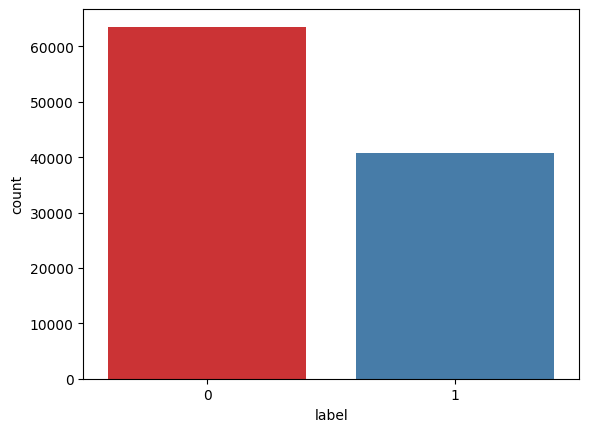

In [ ]:
import seaborn as sns
sns.countplot(data = df, x='label', palette='Set1')

In [ ]:
df['label'].value_counts()

0    63561
1    40784
Name: label, dtype: int64

<Figure size 800x800 with 0 Axes>

([<matplotlib.patches.Wedge at 0x7a9ea05a2c80>,
 [Text(-1.0359686172856162, -0.36982296305033385, 'Benign'),
  Text(1.0359686519109366, 0.3698228660559496, 'Malicious')],
 [Text(-0.5650737912466997, -0.20172161620927298, '60.9'),
  Text(0.5650738101332381, 0.20172156330324523, '39.1')])

Text(0.5, 1.0, 'Percentage of Benign and Maliciuos Requests in dataset')

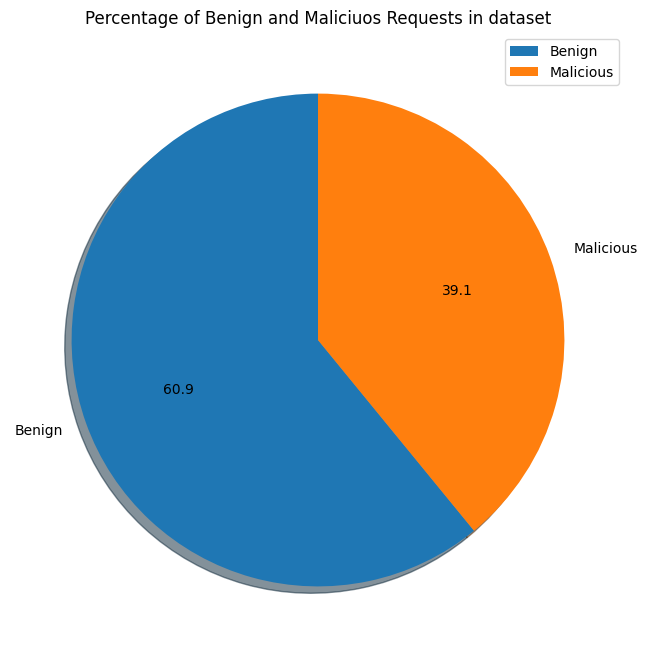

In [279]:
plt.figure(figsize=(8,8))
plt.pie(df["label"].value_counts().values, labels=['Benign', 'Malicious'], autopct='%1.1f',shadow=True, startangle=90)
plt.legend()
plt.title('Percentage of Benign and Maliciuos Requests in dataset')
plt.show()

In [ ]:
df.isnull().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Features which has Null values')

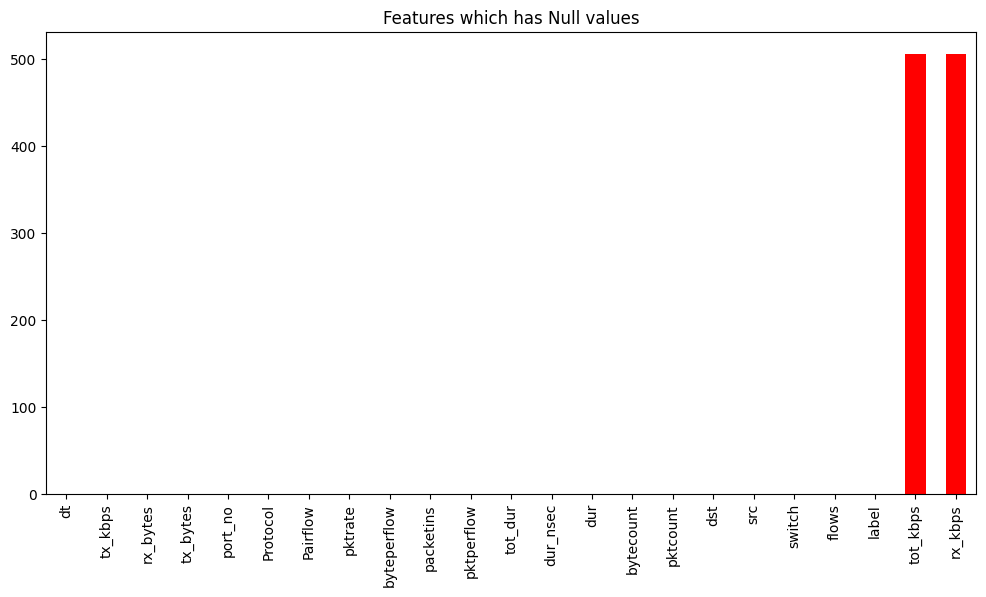

In [ ]:
plt.figure(figsize=(12,6))
df[df.columns[df.isna().sum() >= 0]].isna().sum().sort_values().plot.bar(color='red')
plt.title("Features which has Null values")

<Figure size 1200x700 with 0 Axes>

<BarContainer object of 19 artists>

Text(11491, -0.2, '11491')

Text(10313, 0.8, '10313')

Text(9671, 1.8, '9671')

Text(8645, 2.8, '8645')

Text(8147, 3.8, '8147')

Text(8063, 4.8, '8063')

Text(7291, 5.8, '7291')

Text(7209, 6.8, '7209')

Text(6455, 7.8, '6455')

Text(5999, 8.8, '5999')

Text(5241, 9.8, '5241')

Text(2740, 10.8, '2740')

Text(2590, 11.8, '2590')

Text(2484, 12.8, '2484')

Text(2265, 13.8, '2265')

Text(1858, 14.8, '1858')

Text(1789, 15.8, '1789')

Text(1114, 16.8, '1114')

Text(980, 17.8, '980')

Text(0.5, 0, 'Number of Requests')

Text(0, 0.5, 'IP addres of sender')

Text(0.5, 1.0, 'Number of all reqests')

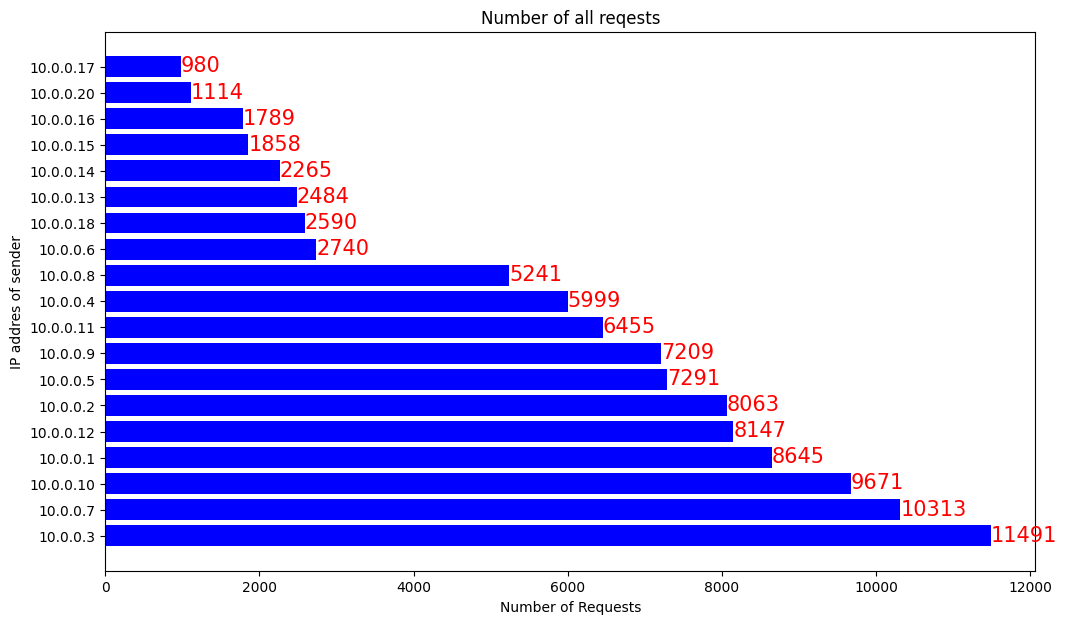

In [ ]:
plt.figure(figsize=(12, 7))
plt.barh(list(dict(df.src.value_counts()).keys()), dict(df.src.value_counts()).values(), color='blue')

for idx, val in enumerate(dict(df.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 15)

plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.title('Number of all reqests')

<Figure size 1200x700 with 0 Axes>

<BarContainer object of 19 artists>

Text(7111, -0.2, '7111')

Text(4968, 0.8, '4968')

Text(3593, 1.8, '3593')

Text(3098, 2.8, '3098')

Text(2676, 3.8, '2676')

Text(2089, 4.8, '2089')

Text(1800, 5.8, '1800')

Text(1773, 6.8, '1773')

Text(1769, 7.8, '1769')

Text(1592, 8.8, '1592')

Text(1515, 9.8, '1515')

Text(1505, 10.8, '1505')

Text(1498, 11.8, '1498')

Text(1451, 12.8, '1451')

Text(1146, 13.8, '1146')

Text(1067, 14.8, '1067')

Text(1040, 15.8, '1040')

Text(648, 16.8, '648')

Text(445, 17.8, '445')

Text(0.5, 0, 'Number of Requests')

Text(0, 0.5, 'IP addres of sender')

Text(0.5, 1.0, 'Number of Attack requests')

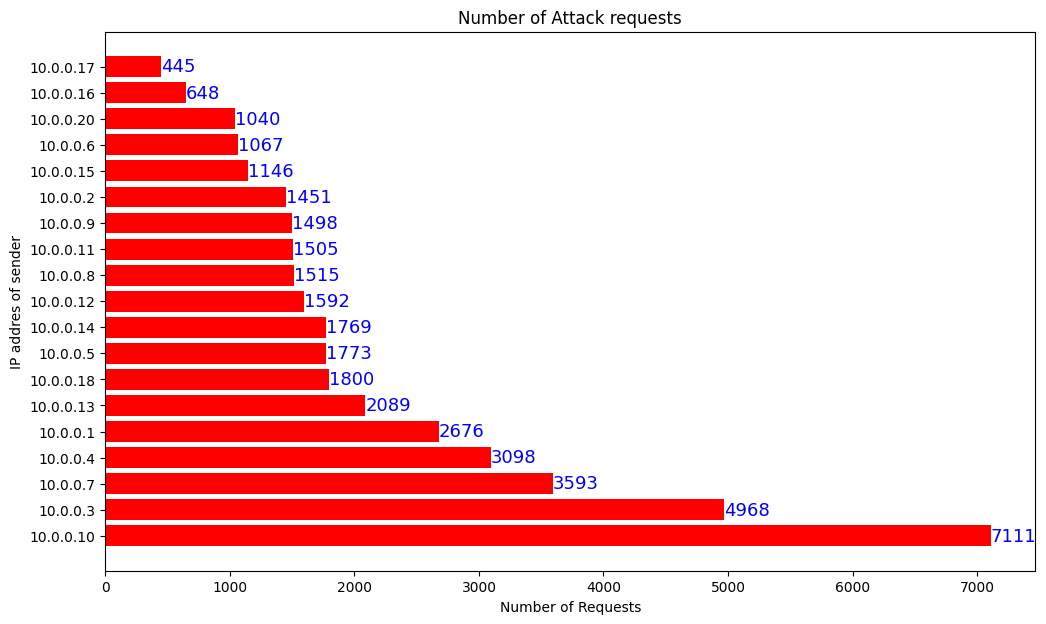

In [ ]:
plt.figure(figsize=(12, 7))
plt.barh(list(dict(df[df.label == 1].src.value_counts()).keys()), dict(df[df.label == 1].src.value_counts()).values(), color='red')

for idx, val in enumerate(dict(df[df.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='b', size = 13)

plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.title('Number of Attack requests')

<Figure size 1500x600 with 0 Axes>

<BarContainer object of 19 artists>

<BarContainer object of 19 artists>

Text(11491, -0.2, '11491')

Text(10313, 0.8, '10313')

Text(9671, 1.8, '9671')

Text(8645, 2.8, '8645')

Text(8147, 3.8, '8147')

Text(8063, 4.8, '8063')

Text(7291, 5.8, '7291')

Text(7209, 6.8, '7209')

Text(6455, 7.8, '6455')

Text(5999, 8.8, '5999')

Text(5241, 9.8, '5241')

Text(2740, 10.8, '2740')

Text(2590, 11.8, '2590')

Text(2484, 12.8, '2484')

Text(2265, 13.8, '2265')

Text(1858, 14.8, '1858')

Text(1789, 15.8, '1789')

Text(1114, 16.8, '1114')

Text(980, 17.8, '980')

Text(7111, -0.2, '7111')

Text(4968, 0.8, '4968')

Text(3593, 1.8, '3593')

Text(3098, 2.8, '3098')

Text(2676, 3.8, '2676')

Text(2089, 4.8, '2089')

Text(1800, 5.8, '1800')

Text(1773, 6.8, '1773')

Text(1769, 7.8, '1769')

Text(1592, 8.8, '1592')

Text(1515, 9.8, '1515')

Text(1505, 10.8, '1505')

Text(1498, 11.8, '1498')

Text(1451, 12.8, '1451')

Text(1146, 13.8, '1146')

Text(1067, 14.8, '1067')

Text(1040, 15.8, '1040')

Text(648, 16.8, '648')

Text(445, 17.8, '445')

Text(0.5, 0, 'Number of Requests')

Text(0, 0.5, 'IP addres of sender')

Text(0.5, 1.0, 'Number of requests from different IP adress')

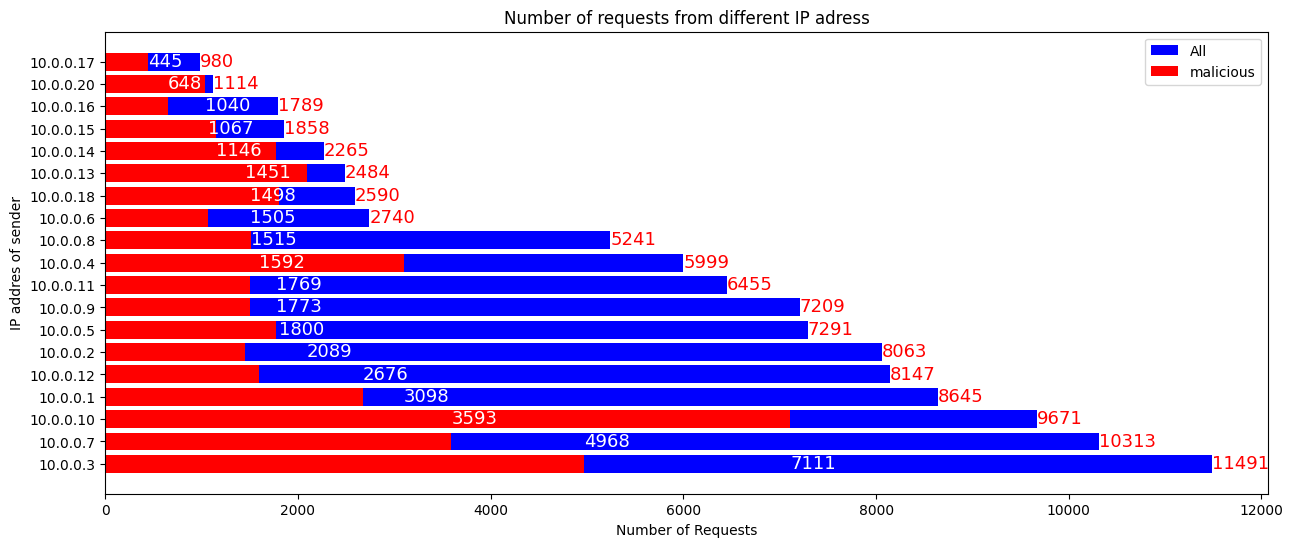

In [ ]:
plt.figure(figsize=(15, 6))
plt.barh(list(dict(df.src.value_counts()).keys()), dict(df.src.value_counts()).values(), color='blue')
plt.barh(list(dict(df[df.label == 1].src.value_counts()).keys()), dict(df[df.label == 1].src.value_counts()).values(), color='red')

for idx, val in enumerate(dict(df.src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='r', size = 13)

for idx, val in enumerate(dict(df[df.label == 1].src.value_counts()).values()):
    plt.text(x = val, y = idx-0.2, s = str(val), color='w', size = 13)


plt.xlabel('Number of Requests')
plt.ylabel('IP addres of sender')
plt.legend(['All','malicious'])
plt.title('Number of requests from different IP adress')


In [ ]:
df[['src', 'dst' ,'tot_dur','rx_kbps']]

,src,dst,tot_dur,rx_kbps
0,10.0.0.1,10.0.0.8,1.010000e+11,0.0
1,10.0.0.1,10.0.0.8,2.810000e+11,0.0
2,10.0.0.2,10.0.0.8,2.010000e+11,0.0
3,10.0.0.2,10.0.0.8,2.010000e+11,0.0
4,10.0.0.2,10.0.0.8,2.010000e+11,0.0
...,...,...,...,...
104340,10.0.0.5,10.0.0.7,8.184200e+10,1.0
104341,10.0.0.5,10.0.0.7,8.184200e+10,1.0
104342,10.0.0.11,10.0.0.5,3.180500e+10,0.0
104343,10.0.0.11,10.0.0.5,3.180500e+10,1.0


In [ ]:
df1=df.drop(labels=['src', 'dst' ,'tot_dur','rx_kbps'], axis=1)

In [ ]:
df1

,dt,switch,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,tot_kbps,label
0,11425,1,45304,48294064,100,716000000,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0
1,11605,1,126395,134737070,280,734000000,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0
2,11425,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0
3,11425,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0
4,11425,1,90333,96294978,200,744000000,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,79,7742,81,842000000,5,10,29,2842,0,0,ICMP,1,15209,12720,1,2.0,0
104341,5262,3,79,7742,81,842000000,5,10,29,2842,0,0,ICMP,3,15099,14693,1,2.0,0
104342,5262,3,31,3038,31,805000000,5,10,30,2940,1,0,ICMP,2,3409,3731,0,0.0,0
104343,5262,3,31,3038,31,805000000,5,10,30,2940,1,0,ICMP,1,15209,12720,1,2.0,0


## 3. Data Pre-Processing

In [ ]:
df[df['pktrate']==0]

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
91,11335,1,10.0.0.1,10.0.0.8,4777,5092282,10,711000000,1.071100e+10,3,...,0,0,UDP,2,3753,1332,0,0.0,0.0,1
92,11335,1,10.0.0.1,10.0.0.8,4777,5092282,10,711000000,1.071100e+10,3,...,0,0,UDP,3,3679,58460931,0,5232.0,5232.0,1
93,11335,1,10.0.0.1,10.0.0.8,4777,5092282,10,711000000,1.071100e+10,3,...,0,0,UDP,2,3733,1402,0,0.0,0.0,1
94,11335,1,10.0.0.1,10.0.0.8,4777,5092282,10,711000000,1.071100e+10,3,...,0,0,UDP,4,58460931,3749,5232,0.0,5232.0,1
95,11335,1,10.0.0.1,10.0.0.8,4777,5092282,10,711000000,1.071100e+10,3,...,0,0,UDP,3,3413,3623,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104337,5262,3,10.0.0.7,10.0.0.5,79,7742,81,867000000,8.186700e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104338,5262,3,10.0.0.7,10.0.0.5,79,7742,81,867000000,8.186700e+10,5,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104339,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,2,3409,3731,0,0.0,0.0,0
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [ ]:

df1 = df1[df1['pktrate'] !=0]

In [ ]:
df[['switch', 'port_no', 'Protocol']]

,switch,port_no,Protocol
0,1,3,UDP
1,1,4,UDP
2,1,1,UDP
3,1,2,UDP
4,1,3,UDP
...,...,...,...
104340,3,1,ICMP
104341,3,3,ICMP
104342,3,2,ICMP
104343,3,1,ICMP


In [ ]:

df1['switch'] = df1['switch'].astype(str)
df1['port_no'] = df1['port_no'].astype(str)
df1['Protocol'] = df1['Protocol'].astype(str)

In [ ]:
new_df1 = pd.get_dummies(df1,columns = ['switch','Protocol'])
new_df1

,dt,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,pktrate,...,switch_3,switch_4,switch_5,switch_6,switch_7,switch_8,switch_9,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,11425,45304,48294064,100,716000000,3,1943,13535,14428310,451,...,0,0,0,0,0,0,0,0,0,1
1,11605,126395,134737070,280,734000000,2,1943,13531,14424046,451,...,0,0,0,0,0,0,0,0,0,1
2,11425,90333,96294978,200,744000000,3,1943,13534,14427244,451,...,0,0,0,0,0,0,0,0,0,1
3,11425,90333,96294978,200,744000000,3,1943,13534,14427244,451,...,0,0,0,0,0,0,0,0,0,1
4,11425,90333,96294978,200,744000000,3,1943,13534,14427244,451,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104130,7602,910,89180,931,540000000,5,3443,30,2940,1,...,0,0,0,0,0,1,0,1,0,0
104131,7602,910,89180,931,540000000,5,3443,30,2940,1,...,0,0,0,0,0,1,0,1,0,0
104342,5262,31,3038,31,805000000,5,10,30,2940,1,...,1,0,0,0,0,0,0,1,0,0
104343,5262,31,3038,31,805000000,5,10,30,2940,1,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
df1.isnull().sum()

dt               0
switch           0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
tot_kbps       463
label            0
dtype: int64

In [ ]:
new_df1.fillna(new_df1.mean(), inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
Le=LabelEncoder()
df1['Protocol']=Le.fit_transform(df1['Protocol'])
df1['tot_kbps']=Le.fit_transform(df1['tot_kbps'])

In [ ]:
df1.isnull().sum()

dt             0
switch         0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
tot_kbps       0
label          0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

<Axes: >

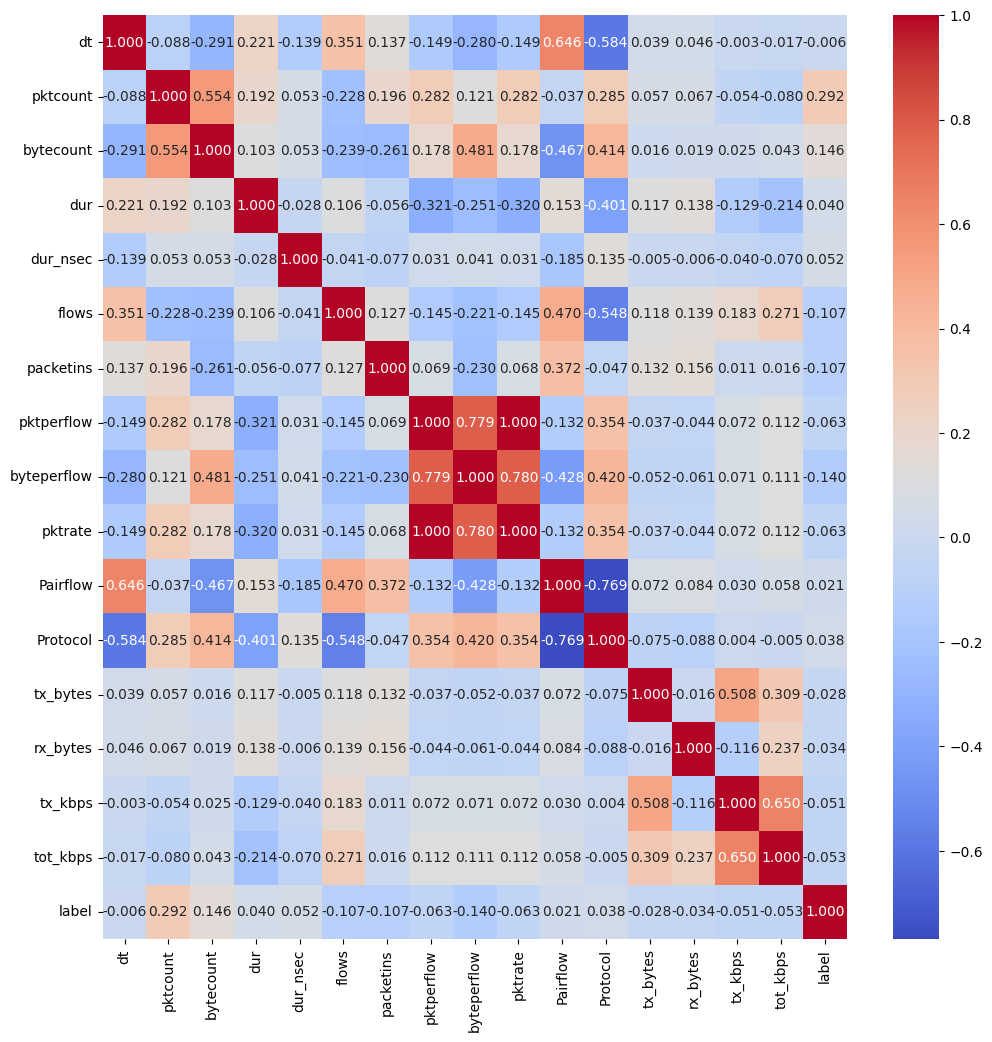

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df1.corr(), fmt='.3f', annot=True, cmap='coolwarm')

In [ ]:
df1.corr()['label']

dt            -0.005954
pktcount       0.291699
bytecount      0.146157
dur            0.040291
dur_nsec       0.051772
flows         -0.107196
packetins     -0.106520
pktperflow    -0.062768
byteperflow   -0.139971
pktrate       -0.063007
Pairflow       0.020515
Protocol       0.038373
tx_bytes      -0.028411
rx_bytes      -0.033697
tx_kbps       -0.050736
tot_kbps      -0.052800
label          1.000000
Name: label, dtype: float64

## 4. Preparing Training and Testing Sets

In [ ]:
x=df1.drop(['label'],axis=1)
y=df1.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)
x_train.head(112)

,dt,switch,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,tot_kbps
27193,3369,4,134681,143569946,312,784000000,4,7916,5655,6028230,188,0,2,1,4462,38248048,0,830
69865,7098,7,24106,1398148,74,864000000,5,11888,8373,485634,279,1,1,1,5012,1172,0,0
1226,10026,1,87039,92783574,193,260000000,2,1931,13535,14428310,451,0,2,2,3444,1242,0,0
4824,11545,3,134801,143697866,319,468000000,5,1943,4288,4571008,142,0,2,3,4211,249913885,0,1479
74433,40983,6,14699,16283206,33,203000000,3,23,13354,14755716,445,1,1,4,3815,3731,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32202,2578,7,39325,41920450,87,250000000,2,1814,13529,14421914,450,0,2,1,3514,1172,0,0
65849,30102,3,97996,102111832,319,870000000,8,2053,9279,9668718,309,1,0,4,237942961,271222567,2574,832
88818,24660,4,32825,34203650,118,81000000,5,2997,8522,8879924,284,1,0,2,32946807,34673317,2359,1373
11463,11305,4,103519,110351254,229,292000000,6,1306,13536,14429376,451,0,2,3,3488,38839874,0,1041


In [ ]:
x_train.columns

Index(['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow',
       'Protocol', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'tot_kbps'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
x_train=scalar.fit_transform(x_train)
x_test=scalar.transform(x_test)

In [ ]:
x_train

array([[-1.08478574, -0.10143675,  1.3384573 , ..., -0.37354796,
        -0.42589124,  0.36905707],
       [-0.76773867,  1.44057939, -0.93066425, ..., -0.65642601,
        -0.42589124, -0.80930034],
       [-0.51879423, -1.64345289,  0.36079066, ..., -0.65642549,
        -0.42589124, -0.80930034],
       ...,
       [-1.12049498, -1.12944751,  1.21524857, ..., -0.65640892,
        -0.42589124, -0.80930034],
       [-1.1000897 , -1.64345289, -1.0804273 , ...,  1.40372778,
        -0.42589124, -0.80930034],
       [ 0.73910637, -1.12944751,  2.4681238 , ..., -0.6175456 ,
        -0.42589124, -0.71276021]])

### Model Analysis Function

## 5. Classification
We now train our ML models to predict whether the traffic is malicious (labelled as "1") or benign (labelled as "0").  


# Gaussian Naive Bayes(GNB)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [258]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_test_pred_gnb = gnb.predict(x_test)
y_train_pred_gnb = gnb.predict(x_train)

GaussianNB()

In [259]:
print("Train score is:", accuracy_score(y_train, y_train_pred_gnb)*100)
print("Test score is:", accuracy_score(y_test, y_test_pred_gnb)*100)

Train score is: 64.80339434604568
Test score is: 64.6888567293777


<Axes: >

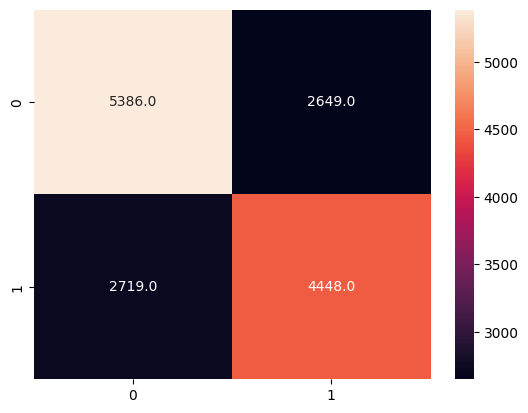

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_test_pred_gnb), annot=True, fmt='.1f')

In [260]:
print(classification_report(y_test,y_test_pred_gnb))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      8035
           1       0.63      0.62      0.62      7167

    accuracy                           0.65     15202
   macro avg       0.65      0.65      0.65     15202
weighted avg       0.65      0.65      0.65     15202



In [ ]:
### Create a Pickle file using serialization
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(gnb, pickle_out)
pickle_out.close()

# Proposed Model

### Support Vector Classifier (SVC)

In [238]:
classifier = SVC(gamma='auto')
classifier.fit(x_train, y_train)
y_pred_classifier = classifier.predict(x_test)
y_pred_train = classifier.predict(x_train)

SVC(gamma='auto')

In [243]:
train_score = accuracy_score(y_train, y_pred_train)
print(f"Train Score is : {train_score*100}")

Train Score is : 96.94278619237917


<Axes: >

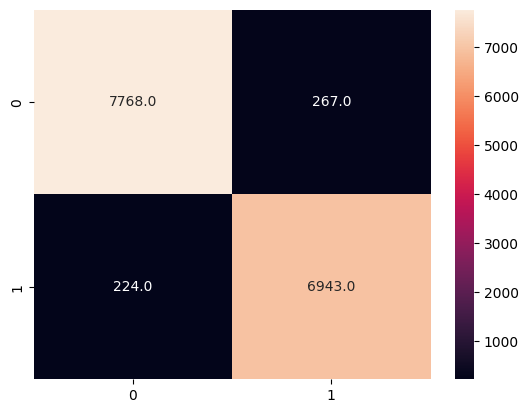

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred_classifier), annot=True, fmt='.1f')

In [241]:
print(classification_report(y_test,y_pred_classifier))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8035
           1       0.96      0.97      0.97      7167

    accuracy                           0.97     15202
   macro avg       0.97      0.97      0.97     15202
weighted avg       0.97      0.97      0.97     15202



### Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [244]:
dt = DecisionTreeClassifier()


dt.fit(x_train, y_train)
dt_train_pred = dt.predict(x_train)
dt_test_pred = dt.predict(x_test)

print("Train score is:", accuracy_score(y_train, dt_train_pred)*100)
print("Test score is:", accuracy_score(y_test, dt_test_pred)*100)


DecisionTreeClassifier()

Train score is: 100.0
Test score is: 100.0


<Axes: >

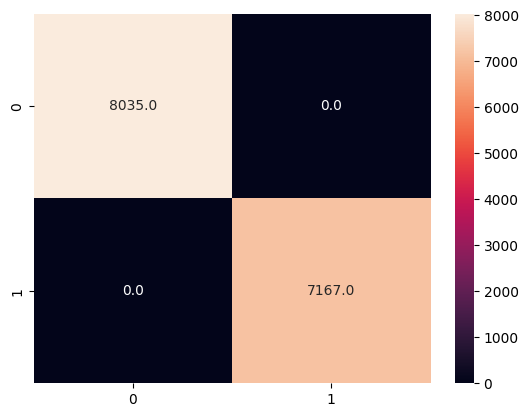

In [246]:
sns.heatmap(confusion_matrix(y_test, dt_test_pred), fmt='.1f', annot=True)

In [247]:
print(classification_report(y_test, dt_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8035
           1       1.00      1.00      1.00      7167

    accuracy                           1.00     15202
   macro avg       1.00      1.00      1.00     15202
weighted avg       1.00      1.00      1.00     15202



##Random Forest Classifier

In [252]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier()
rc.fit(x_train, y_train)
rc_test_pred = rc.predict(x_test)
rc_train_pred = rc.predict(x_train)
print(f"Train score is : {accuracy_score(y_train, rc_train_pred)*100}")
print(f"Test score is : {accuracy_score(y_test, rc_test_pred)*100}")

RandomForestClassifier()

Train score is : 100.0
Test score is : 100.0


<Axes: >

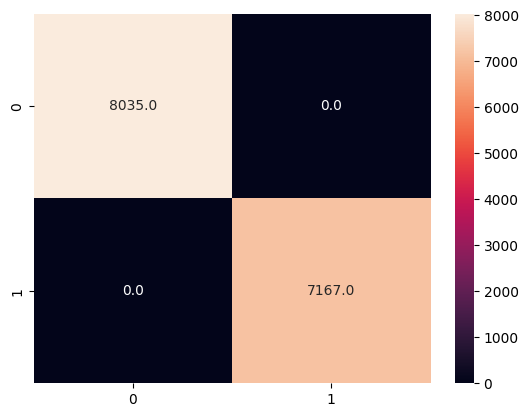

In [255]:
sns.heatmap(confusion_matrix(y_test, rc_test_pred), fmt='.1f', annot=True)

In [256]:
print(classification_report(y_test, rc_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8035
           1       1.00      1.00      1.00      7167

    accuracy                           1.00     15202
   macro avg       1.00      1.00      1.00     15202
weighted avg       1.00      1.00      1.00     15202



##XGBoost

In [257]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(x_train, y_train)

xgb_train_pred = xgb.predict(x_train)

xgb_test_pred = xgb.predict(x_test)

print(f"Train score is : {accuracy_score(y_train, xgb_train_pred)*100}")
print(f"Test score is : {accuracy_score(y_test, xgb_test_pred)*100}")



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Train score is : 100.0
Test score is : 100.0


## 6. Analysis

In [261]:
print(classification_report(y_test,y_test_pred_gnb))


              precision    recall  f1-score   support

           0       0.66      0.67      0.67      8035
           1       0.63      0.62      0.62      7167

    accuracy                           0.65     15202
   macro avg       0.65      0.65      0.65     15202
weighted avg       0.65      0.65      0.65     15202



In [265]:
from tabulate import tabulate
print('N:Normal ')
print('A:Attack')
headers = ('Algo ','Acc','N Prec','A Prec','N Rec','A Rec','N F-score','A F-score','FPR','FNR')
data2 = ['SVC',0.98,0.98,0.97,0.98,0.98,0.98,0.97,0.023,0.024]
data3 = ['DT',1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0]
data1 = ['GNB',0.66,0.66,0.67,0.62,0.67,0.62,0.67,0.62,0.71]
data4 = ['RF',1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0]
data5 = ['XGB',1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0]

data = [data1, data2,data3,data4, data5]
print(tabulate(data, headers=headers, tablefmt='grid'))

N:Normal 
A:Attack
+---------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| Algo    |   Acc |   N Prec |   A Prec |   N Rec |   A Rec |   N F-score |   A F-score |   FPR |   FNR |
+=========+=======+==========+==========+=========+=========+=============+=============+=======+=======+
| GNB     |  0.66 |     0.66 |     0.67 |    0.62 |    0.67 |        0.62 |        0.67 | 0.62  | 0.71  |
+---------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| SVC     |  0.98 |     0.98 |     0.97 |    0.98 |    0.98 |        0.98 |        0.97 | 0.023 | 0.024 |
+---------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| DT      |  1    |     1    |     1    |    1    |    1    |        1    |        1    | 0     | 0     |
+---------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| RF      |  1    |     1  

## Predictive System

In [267]:
x_train.shape

(60807, 18)

In [270]:
x_train

array([[-1.08478574, -0.10143675,  1.3384573 , ..., -0.37354796,
        -0.42589124,  0.36905707],
       [-0.76773867,  1.44057939, -0.93066425, ..., -0.65642601,
        -0.42589124, -0.80930034],
       [-0.51879423, -1.64345289,  0.36079066, ..., -0.65642549,
        -0.42589124, -0.80930034],
       ...,
       [-1.12049498, -1.12944751,  1.21524857, ..., -0.65640892,
        -0.42589124, -0.80930034],
       [-1.1000897 , -1.64345289, -1.0804273 , ...,  1.40372778,
        -0.42589124, -0.80930034],
       [ 0.73910637, -1.12944751,  2.4681238 , ..., -0.6175456 ,
        -0.42589124, -0.71276021]])

In [268]:
cols = ['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow',
       'Protocol', 'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'tot_kbps']

In [ ]:
inp = []
for c in cols:
  inp.append(int(input(f"Enter {c}: ")))

array = np.asarray(inp)
array = array.reshape(1,-1)
ans = xgb.predict(array)
print(ans[0])

if ans[0]==0:
  print("Result: Benign")
else:
  print("Malicious")

